In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing 

def prepare_data(df):
    # df=df_data.drop(['name'], axis=1)  #删除name列
    # 缺失值处理
    age_mean = df['age'].mean()
    df['age'] = df['age'].fillna(age_mean)# 为na的age填充均值
    fare_mean = df['fare'].mean()
    df['fare'] = df['fare'].fillna(fare_mean)
    df['embarked'] = df['embarked'].fillna('S')
    # 数值都转成int
    df['sex'] = df['sex'].map({'male':1, 'female':0}).astype(int)
    df['embarked'] = df['embarked'].map({'C':0, 'Q':1,'S':2}).astype(int)
    
    #分离特征值和标签值
    ndarray_data = df.values
    features = ndarray_data[:,1:]
    label = ndarray_data[:,0]
    
    # 特征值标准化
    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0,1))
    norm_features = minmax_scale.fit_transform(features)
    
    return norm_features, label
    
    

In [2]:
data_file_path = "data/titanic3.xls"
df_data = pd.read_excel(data_file_path)

# 筛选字段
# 提取有用的特征字段
selected_cols = ['survived', 'pclass','sex','age','sibsp','parch','fare','embarked']

selected_df_data = df_data[selected_cols]

In [3]:
# 通过pandas sample进行随机排序， frac 百分比 。 selected_df_data 保持不变
shuffle_data = selected_df_data.sample(frac=1)
x_data, y_data = prepare_data(shuffle_data)

# 划分训练集和测试集，这里80%作为训练集
train_size = int(len(x_data)*0.8)

x_train = x_data[:train_size]
y_train = y_data[:train_size]
x_test = x_data[train_size:]
y_test = y_data[train_size:]

In [4]:
# 输入层 - 隐藏层1 64个 - 隐藏层2 32个 - 输出层 1个神经元
import tensorflow as tf
# 建立Keras序列模型
model = tf.keras.models.Sequential()

In [5]:
# 这段代码比低阶api节省了好多事
# 第一隐藏层层，输入特征数据是7列，也可用input_shape(7,)
model.add(tf.keras.layers.Dense(units=64,  # 输出神经元数量
                                input_dim=7, #输出数据个数
                                use_bias=True, #启用偏置项
                                kernel_initializer='uniform', #权重初始化方式
                                bias_initializer='zeros', #偏置项初识为0
                                activation='relu')) # 激活函数用relu

# 第二隐藏层，这里很多都可以用缺省值。输入数据维度会由上一个层计算得到
model.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))

# 输出层
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

#显示模型结构
# model.summary()
# 其中 参数个数，因为有偏置项，  (7+1)*64， (64+1) *32, (32+1)*1


In [13]:
# 模型设置
model.compile(optimizer=tf.keras.optimizers.Adam(0.003),  # 优化器
             loss='binary_crossentropy', # 损失函数
             metrics=['accuracy']) # 监控度量值=准确率
# sigmoid 作为激活函数时，损失函数常用binary_crossentropy
# softmax 作为激活函数时，损失函数选用categorical_crossentropy

# 设置回调参数，内置的回调还包括
# tf.keras.callbacks.LearningRateScheduler() #动态调整学习率
# tf.keras.callbacks.EarlyStopping()  #因为迭代次数过多会造成过拟合，方案是：随机丢弃神经元/早停

import os 

logdir='./logs'
checkpoint_path = './checkpoint/Titanic.{epoch:02d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# 最近一次 存盘训练结果
latest = tf.train.latest_checkpoint(checkpoint_dir=checkpoint_dir)
# print(model.load_weights(latest))

# period 已过期 用save_freq代替
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=2), # 日志路径，直方图存储频率
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, #模型检查点， 保存路径
                                       save_weights_only=True, # 只保存权重的值。不保存模型定义，恢复时需要重建模型定义。如果设False可以直接恢复模型定义
                                       verbose=1, 
                                       save_freq=5)# 保存周期
]

In [8]:
# 训练模型
train_history = model.fit(x = x_train,
                          y = y_train,
                          validation_split = 0.2, # 8/2开拆分样本集和测试集，验证集所占比例
                          epochs = 100,
                          batch_size = 40,
                          callbacks = callbacks,  # 传入回调
                          verbose = 1)  # 训练过程 0 - 不显示,1 - 进度条  ,2 - 每个epoch显示一行


# 返回值是训练过程的loss和acc数据，以及验证过程（如有）
# 可以通过.history 查看
# print(train_history.history)

Train on 837 samples, validate on 210 samples
Epoch 1/100

Epoch 00001: saving model to ./checkpoint/Titanic.01.ckpt
 40/837 [>.............................] - ETA: 13s - loss: 0.9076 - accuracy: 0.2500
Epoch 00001: saving model to ./checkpoint/Titanic.01.ckpt

Epoch 00001: saving model to ./checkpoint/Titanic.01.ckpt
120/837 [===>..........................] - ETA: 4s - loss: 0.8477 - accuracy: 0.3083 
Epoch 00001: saving model to ./checkpoint/Titanic.01.ckpt

Epoch 00001: saving model to ./checkpoint/Titanic.01.ckpt
200/837 [======>.......................] - ETA: 2s - loss: 0.8014 - accuracy: 0.3650
Epoch 00001: saving model to ./checkpoint/Titanic.01.ckpt

Epoch 00001: saving model to ./checkpoint/Titanic.01.ckpt

Epoch 00001: saving model to ./checkpoint/Titanic.01.ckpt
320/837 [==========>...................] - ETA: 1s - loss: 0.7658 - accuracy: 0.4000
Epoch 00001: saving model to ./checkpoint/Titanic.01.ckpt

Epoch 00001: saving model to ./checkpoint/Titanic.01.ckpt

Epoch 00001: 

Epoch 00004: saving model to ./checkpoint/Titanic.04.ckpt
680/837 [=======================>......] - ETA: 0s - loss: 0.4992 - accuracy: 0.7588
Epoch 00004: saving model to ./checkpoint/Titanic.04.ckpt

Epoch 00004: saving model to ./checkpoint/Titanic.04.ckpt
760/837 [==========================>...] - ETA: 0s - loss: 0.5016 - accuracy: 0.7566
Epoch 00004: saving model to ./checkpoint/Titanic.04.ckpt

Epoch 00004: saving model to ./checkpoint/Titanic.04.ckpt
837/837 [==============================] - 1s 686us/sample - loss: 0.4973 - accuracy: 0.7599 - val_loss: 0.4798 - val_accuracy: 0.8143
Epoch 5/100

Epoch 00005: saving model to ./checkpoint/Titanic.05.ckpt
 40/837 [>.............................] - ETA: 0s - loss: 0.4993 - accuracy: 0.7750
Epoch 00005: saving model to ./checkpoint/Titanic.05.ckpt

Epoch 00005: saving model to ./checkpoint/Titanic.05.ckpt
120/837 [===>..........................] - ETA: 0s - loss: 0.4842 - accuracy: 0.7917
Epoch 00005: saving model to ./checkpoint/Tit

440/837 [==============>...............] - ETA: 0s - loss: 0.4455 - accuracy: 0.8114
Epoch 00008: saving model to ./checkpoint/Titanic.08.ckpt

Epoch 00008: saving model to ./checkpoint/Titanic.08.ckpt
520/837 [=================>............] - ETA: 0s - loss: 0.4504 - accuracy: 0.8038
Epoch 00008: saving model to ./checkpoint/Titanic.08.ckpt

Epoch 00008: saving model to ./checkpoint/Titanic.08.ckpt

Epoch 00008: saving model to ./checkpoint/Titanic.08.ckpt
640/837 [=====================>........] - ETA: 0s - loss: 0.4493 - accuracy: 0.8047
Epoch 00008: saving model to ./checkpoint/Titanic.08.ckpt

Epoch 00008: saving model to ./checkpoint/Titanic.08.ckpt
720/837 [========================>.....] - ETA: 0s - loss: 0.4592 - accuracy: 0.8028
Epoch 00008: saving model to ./checkpoint/Titanic.08.ckpt

Epoch 00008: saving model to ./checkpoint/Titanic.08.ckpt

Epoch 00008: saving model to ./checkpoint/Titanic.08.ckpt
837/837 [==============================] - 1s 661us/sample - loss: 0.4712 

200/837 [======>.......................] - ETA: 0s - loss: 0.4778 - accuracy: 0.7950
Epoch 00012: saving model to ./checkpoint/Titanic.12.ckpt

Epoch 00012: saving model to ./checkpoint/Titanic.12.ckpt
280/837 [=========>....................] - ETA: 0s - loss: 0.5074 - accuracy: 0.7786
Epoch 00012: saving model to ./checkpoint/Titanic.12.ckpt

Epoch 00012: saving model to ./checkpoint/Titanic.12.ckpt
360/837 [===========>..................] - ETA: 0s - loss: 0.4842 - accuracy: 0.7917
Epoch 00012: saving model to ./checkpoint/Titanic.12.ckpt

Epoch 00012: saving model to ./checkpoint/Titanic.12.ckpt
440/837 [==============>...............] - ETA: 0s - loss: 0.4781 - accuracy: 0.7955
Epoch 00012: saving model to ./checkpoint/Titanic.12.ckpt

Epoch 00012: saving model to ./checkpoint/Titanic.12.ckpt

Epoch 00012: saving model to ./checkpoint/Titanic.12.ckpt
560/837 [===================>..........] - ETA: 0s - loss: 0.4711 - accuracy: 0.7946
Epoch 00012: saving model to ./checkpoint/Titani

 40/837 [>.............................] - ETA: 0s - loss: 0.3738 - accuracy: 0.8750
Epoch 00016: saving model to ./checkpoint/Titanic.16.ckpt

Epoch 00016: saving model to ./checkpoint/Titanic.16.ckpt
120/837 [===>..........................] - ETA: 0s - loss: 0.5117 - accuracy: 0.7667
Epoch 00016: saving model to ./checkpoint/Titanic.16.ckpt

Epoch 00016: saving model to ./checkpoint/Titanic.16.ckpt
200/837 [======>.......................] - ETA: 0s - loss: 0.5007 - accuracy: 0.7750
Epoch 00016: saving model to ./checkpoint/Titanic.16.ckpt

Epoch 00016: saving model to ./checkpoint/Titanic.16.ckpt

Epoch 00016: saving model to ./checkpoint/Titanic.16.ckpt
320/837 [==========>...................] - ETA: 0s - loss: 0.4674 - accuracy: 0.7812
Epoch 00016: saving model to ./checkpoint/Titanic.16.ckpt

Epoch 00016: saving model to ./checkpoint/Titanic.16.ckpt
400/837 [=============>................] - ETA: 0s - loss: 0.4488 - accuracy: 0.7925
Epoch 00016: saving model to ./checkpoint/Titani

Epoch 00019: saving model to ./checkpoint/Titanic.19.ckpt
720/837 [========================>.....] - ETA: 0s - loss: 0.4519 - accuracy: 0.7903
Epoch 00019: saving model to ./checkpoint/Titanic.19.ckpt

Epoch 00019: saving model to ./checkpoint/Titanic.19.ckpt

Epoch 00019: saving model to ./checkpoint/Titanic.19.ckpt
837/837 [==============================] - 1s 679us/sample - loss: 0.4542 - accuracy: 0.7933 - val_loss: 0.4612 - val_accuracy: 0.7905
Epoch 20/100

Epoch 00020: saving model to ./checkpoint/Titanic.20.ckpt
 40/837 [>.............................] - ETA: 0s - loss: 0.4793 - accuracy: 0.7750
Epoch 00020: saving model to ./checkpoint/Titanic.20.ckpt

Epoch 00020: saving model to ./checkpoint/Titanic.20.ckpt
120/837 [===>..........................] - ETA: 0s - loss: 0.4694 - accuracy: 0.7500
Epoch 00020: saving model to ./checkpoint/Titanic.20.ckpt

Epoch 00020: saving model to ./checkpoint/Titanic.20.ckpt

Epoch 00020: saving model to ./checkpoint/Titanic.20.ckpt
240/837 [==

480/837 [================>.............] - ETA: 0s - loss: 0.4855 - accuracy: 0.7583
Epoch 00023: saving model to ./checkpoint/Titanic.23.ckpt

Epoch 00023: saving model to ./checkpoint/Titanic.23.ckpt
560/837 [===================>..........] - ETA: 0s - loss: 0.4849 - accuracy: 0.7589
Epoch 00023: saving model to ./checkpoint/Titanic.23.ckpt

Epoch 00023: saving model to ./checkpoint/Titanic.23.ckpt
640/837 [=====================>........] - ETA: 0s - loss: 0.4721 - accuracy: 0.7641
Epoch 00023: saving model to ./checkpoint/Titanic.23.ckpt

Epoch 00023: saving model to ./checkpoint/Titanic.23.ckpt
720/837 [========================>.....] - ETA: 0s - loss: 0.4779 - accuracy: 0.7639
Epoch 00023: saving model to ./checkpoint/Titanic.23.ckpt

Epoch 00023: saving model to ./checkpoint/Titanic.23.ckpt
800/837 [===========================>..] - ETA: 0s - loss: 0.4698 - accuracy: 0.7713
Epoch 00023: saving model to ./checkpoint/Titanic.23.ckpt
837/837 [==============================] - 1s 682

240/837 [=======>......................] - ETA: 0s - loss: 0.4235 - accuracy: 0.8167
Epoch 00027: saving model to ./checkpoint/Titanic.27.ckpt

Epoch 00027: saving model to ./checkpoint/Titanic.27.ckpt
320/837 [==========>...................] - ETA: 0s - loss: 0.4415 - accuracy: 0.8094
Epoch 00027: saving model to ./checkpoint/Titanic.27.ckpt

Epoch 00027: saving model to ./checkpoint/Titanic.27.ckpt
400/837 [=============>................] - ETA: 0s - loss: 0.4448 - accuracy: 0.8100
Epoch 00027: saving model to ./checkpoint/Titanic.27.ckpt

Epoch 00027: saving model to ./checkpoint/Titanic.27.ckpt

Epoch 00027: saving model to ./checkpoint/Titanic.27.ckpt
520/837 [=================>............] - ETA: 0s - loss: 0.4364 - accuracy: 0.8096
Epoch 00027: saving model to ./checkpoint/Titanic.27.ckpt

Epoch 00027: saving model to ./checkpoint/Titanic.27.ckpt
600/837 [====================>.........] - ETA: 0s - loss: 0.4568 - accuracy: 0.7933
Epoch 00027: saving model to ./checkpoint/Titani

Epoch 31/100

Epoch 00031: saving model to ./checkpoint/Titanic.31.ckpt
 40/837 [>.............................] - ETA: 0s - loss: 0.3123 - accuracy: 0.8250
Epoch 00031: saving model to ./checkpoint/Titanic.31.ckpt

Epoch 00031: saving model to ./checkpoint/Titanic.31.ckpt
120/837 [===>..........................] - ETA: 0s - loss: 0.4006 - accuracy: 0.8083
Epoch 00031: saving model to ./checkpoint/Titanic.31.ckpt

Epoch 00031: saving model to ./checkpoint/Titanic.31.ckpt

Epoch 00031: saving model to ./checkpoint/Titanic.31.ckpt
240/837 [=======>......................] - ETA: 0s - loss: 0.4365 - accuracy: 0.8000
Epoch 00031: saving model to ./checkpoint/Titanic.31.ckpt

Epoch 00031: saving model to ./checkpoint/Titanic.31.ckpt
320/837 [==========>...................] - ETA: 0s - loss: 0.4812 - accuracy: 0.7875
Epoch 00031: saving model to ./checkpoint/Titanic.31.ckpt

Epoch 00031: saving model to ./checkpoint/Titanic.31.ckpt
400/837 [=============>................] - ETA: 0s - loss: 0.


Epoch 00034: saving model to ./checkpoint/Titanic.34.ckpt
720/837 [========================>.....] - ETA: 0s - loss: 0.4631 - accuracy: 0.7764
Epoch 00034: saving model to ./checkpoint/Titanic.34.ckpt

Epoch 00034: saving model to ./checkpoint/Titanic.34.ckpt
800/837 [===========================>..] - ETA: 0s - loss: 0.4480 - accuracy: 0.7900
Epoch 00034: saving model to ./checkpoint/Titanic.34.ckpt
837/837 [==============================] - 1s 693us/sample - loss: 0.4480 - accuracy: 0.7897 - val_loss: 0.4448 - val_accuracy: 0.7905
Epoch 35/100

Epoch 00035: saving model to ./checkpoint/Titanic.35.ckpt
 40/837 [>.............................] - ETA: 0s - loss: 0.4904 - accuracy: 0.7750
Epoch 00035: saving model to ./checkpoint/Titanic.35.ckpt

Epoch 00035: saving model to ./checkpoint/Titanic.35.ckpt
120/837 [===>..........................] - ETA: 0s - loss: 0.4381 - accuracy: 0.8083
Epoch 00035: saving model to ./checkpoint/Titanic.35.ckpt

Epoch 00035: saving model to ./checkpoint/T

440/837 [==============>...............] - ETA: 0s - loss: 0.4364 - accuracy: 0.8091
Epoch 00038: saving model to ./checkpoint/Titanic.38.ckpt

Epoch 00038: saving model to ./checkpoint/Titanic.38.ckpt
520/837 [=================>............] - ETA: 0s - loss: 0.4417 - accuracy: 0.8115
Epoch 00038: saving model to ./checkpoint/Titanic.38.ckpt

Epoch 00038: saving model to ./checkpoint/Titanic.38.ckpt
600/837 [====================>.........] - ETA: 0s - loss: 0.4574 - accuracy: 0.7967
Epoch 00038: saving model to ./checkpoint/Titanic.38.ckpt

Epoch 00038: saving model to ./checkpoint/Titanic.38.ckpt
680/837 [=======================>......] - ETA: 0s - loss: 0.4596 - accuracy: 0.7971
Epoch 00038: saving model to ./checkpoint/Titanic.38.ckpt

Epoch 00038: saving model to ./checkpoint/Titanic.38.ckpt

Epoch 00038: saving model to ./checkpoint/Titanic.38.ckpt
800/837 [===========================>..] - ETA: 0s - loss: 0.4465 - accuracy: 0.8037
Epoch 00038: saving model to ./checkpoint/Titani

Epoch 00042: saving model to ./checkpoint/Titanic.42.ckpt
200/837 [======>.......................] - ETA: 0s - loss: 0.4124 - accuracy: 0.8400
Epoch 00042: saving model to ./checkpoint/Titanic.42.ckpt

Epoch 00042: saving model to ./checkpoint/Titanic.42.ckpt
280/837 [=========>....................] - ETA: 0s - loss: 0.3885 - accuracy: 0.8464
Epoch 00042: saving model to ./checkpoint/Titanic.42.ckpt

Epoch 00042: saving model to ./checkpoint/Titanic.42.ckpt
360/837 [===========>..................] - ETA: 0s - loss: 0.4142 - accuracy: 0.8333
Epoch 00042: saving model to ./checkpoint/Titanic.42.ckpt

Epoch 00042: saving model to ./checkpoint/Titanic.42.ckpt
440/837 [==============>...............] - ETA: 0s - loss: 0.4306 - accuracy: 0.8182
Epoch 00042: saving model to ./checkpoint/Titanic.42.ckpt

Epoch 00042: saving model to ./checkpoint/Titanic.42.ckpt
520/837 [=================>............] - ETA: 0s - loss: 0.4583 - accuracy: 0.8019
Epoch 00042: saving model to ./checkpoint/Titanic

837/837 [==============================] - 1s 731us/sample - loss: 0.4457 - accuracy: 0.7993 - val_loss: 0.4384 - val_accuracy: 0.8143
Epoch 46/100

Epoch 00046: saving model to ./checkpoint/Titanic.46.ckpt
 40/837 [>.............................] - ETA: 0s - loss: 0.3579 - accuracy: 0.8500
Epoch 00046: saving model to ./checkpoint/Titanic.46.ckpt

Epoch 00046: saving model to ./checkpoint/Titanic.46.ckpt
120/837 [===>..........................] - ETA: 0s - loss: 0.4100 - accuracy: 0.8167
Epoch 00046: saving model to ./checkpoint/Titanic.46.ckpt

Epoch 00046: saving model to ./checkpoint/Titanic.46.ckpt
200/837 [======>.......................] - ETA: 0s - loss: 0.4473 - accuracy: 0.8100
Epoch 00046: saving model to ./checkpoint/Titanic.46.ckpt

Epoch 00046: saving model to ./checkpoint/Titanic.46.ckpt

Epoch 00046: saving model to ./checkpoint/Titanic.46.ckpt
320/837 [==========>...................] - ETA: 0s - loss: 0.4432 - accuracy: 0.8219
Epoch 00046: saving model to ./checkpoint/T

600/837 [====================>.........] - ETA: 0s - loss: 0.4440 - accuracy: 0.8033
Epoch 00049: saving model to ./checkpoint/Titanic.49.ckpt

Epoch 00049: saving model to ./checkpoint/Titanic.49.ckpt
680/837 [=======================>......] - ETA: 0s - loss: 0.4446 - accuracy: 0.7985
Epoch 00049: saving model to ./checkpoint/Titanic.49.ckpt

Epoch 00049: saving model to ./checkpoint/Titanic.49.ckpt
760/837 [==========================>...] - ETA: 0s - loss: 0.4504 - accuracy: 0.7947
Epoch 00049: saving model to ./checkpoint/Titanic.49.ckpt

Epoch 00049: saving model to ./checkpoint/Titanic.49.ckpt
837/837 [==============================] - 1s 689us/sample - loss: 0.4477 - accuracy: 0.7957 - val_loss: 0.4400 - val_accuracy: 0.8048
Epoch 50/100

Epoch 00050: saving model to ./checkpoint/Titanic.50.ckpt
 40/837 [>.............................] - ETA: 0s - loss: 0.5753 - accuracy: 0.8000
Epoch 00050: saving model to ./checkpoint/Titanic.50.ckpt

Epoch 00050: saving model to ./checkpoint/T


Epoch 00053: saving model to ./checkpoint/Titanic.53.ckpt
360/837 [===========>..................] - ETA: 0s - loss: 0.4747 - accuracy: 0.7778
Epoch 00053: saving model to ./checkpoint/Titanic.53.ckpt

Epoch 00053: saving model to ./checkpoint/Titanic.53.ckpt
440/837 [==============>...............] - ETA: 0s - loss: 0.4717 - accuracy: 0.7773
Epoch 00053: saving model to ./checkpoint/Titanic.53.ckpt

Epoch 00053: saving model to ./checkpoint/Titanic.53.ckpt
520/837 [=================>............] - ETA: 0s - loss: 0.4594 - accuracy: 0.7865
Epoch 00053: saving model to ./checkpoint/Titanic.53.ckpt

Epoch 00053: saving model to ./checkpoint/Titanic.53.ckpt
600/837 [====================>.........] - ETA: 0s - loss: 0.4515 - accuracy: 0.7950
Epoch 00053: saving model to ./checkpoint/Titanic.53.ckpt

Epoch 00053: saving model to ./checkpoint/Titanic.53.ckpt
680/837 [=======================>......] - ETA: 0s - loss: 0.4728 - accuracy: 0.7779
Epoch 00053: saving model to ./checkpoint/Titani

 40/837 [>.............................] - ETA: 0s - loss: 0.3422 - accuracy: 0.8250
Epoch 00057: saving model to ./checkpoint/Titanic.57.ckpt

Epoch 00057: saving model to ./checkpoint/Titanic.57.ckpt
120/837 [===>..........................] - ETA: 0s - loss: 0.3739 - accuracy: 0.8500
Epoch 00057: saving model to ./checkpoint/Titanic.57.ckpt

Epoch 00057: saving model to ./checkpoint/Titanic.57.ckpt
200/837 [======>.......................] - ETA: 0s - loss: 0.4019 - accuracy: 0.8300
Epoch 00057: saving model to ./checkpoint/Titanic.57.ckpt

Epoch 00057: saving model to ./checkpoint/Titanic.57.ckpt
280/837 [=========>....................] - ETA: 0s - loss: 0.4503 - accuracy: 0.8000
Epoch 00057: saving model to ./checkpoint/Titanic.57.ckpt

Epoch 00057: saving model to ./checkpoint/Titanic.57.ckpt
360/837 [===========>..................] - ETA: 0s - loss: 0.4697 - accuracy: 0.7861
Epoch 00057: saving model to ./checkpoint/Titanic.57.ckpt

Epoch 00057: saving model to ./checkpoint/Titani


Epoch 00060: saving model to ./checkpoint/Titanic.60.ckpt
680/837 [=======================>......] - ETA: 0s - loss: 0.4378 - accuracy: 0.7971
Epoch 00060: saving model to ./checkpoint/Titanic.60.ckpt

Epoch 00060: saving model to ./checkpoint/Titanic.60.ckpt
760/837 [==========================>...] - ETA: 0s - loss: 0.4421 - accuracy: 0.7987
Epoch 00060: saving model to ./checkpoint/Titanic.60.ckpt

Epoch 00060: saving model to ./checkpoint/Titanic.60.ckpt
837/837 [==============================] - 1s 727us/sample - loss: 0.4473 - accuracy: 0.7957 - val_loss: 0.4527 - val_accuracy: 0.8000
Epoch 61/100

Epoch 00061: saving model to ./checkpoint/Titanic.61.ckpt
 40/837 [>.............................] - ETA: 0s - loss: 0.5222 - accuracy: 0.7500
Epoch 00061: saving model to ./checkpoint/Titanic.61.ckpt

Epoch 00061: saving model to ./checkpoint/Titanic.61.ckpt
120/837 [===>..........................] - ETA: 0s - loss: 0.4632 - accuracy: 0.8000
Epoch 00061: saving model to ./checkpoint/T

360/837 [===========>..................] - ETA: 0s - loss: 0.4642 - accuracy: 0.7944
Epoch 00064: saving model to ./checkpoint/Titanic.64.ckpt

Epoch 00064: saving model to ./checkpoint/Titanic.64.ckpt
440/837 [==============>...............] - ETA: 0s - loss: 0.4588 - accuracy: 0.8000
Epoch 00064: saving model to ./checkpoint/Titanic.64.ckpt

Epoch 00064: saving model to ./checkpoint/Titanic.64.ckpt
520/837 [=================>............] - ETA: 0s - loss: 0.4594 - accuracy: 0.7962
Epoch 00064: saving model to ./checkpoint/Titanic.64.ckpt

Epoch 00064: saving model to ./checkpoint/Titanic.64.ckpt
600/837 [====================>.........] - ETA: 0s - loss: 0.4528 - accuracy: 0.8000
Epoch 00064: saving model to ./checkpoint/Titanic.64.ckpt

Epoch 00064: saving model to ./checkpoint/Titanic.64.ckpt
680/837 [=======================>......] - ETA: 0s - loss: 0.4446 - accuracy: 0.8044
Epoch 00064: saving model to ./checkpoint/Titanic.64.ckpt

Epoch 00064: saving model to ./checkpoint/Titani

120/837 [===>..........................] - ETA: 0s - loss: 0.3039 - accuracy: 0.8750
Epoch 00068: saving model to ./checkpoint/Titanic.68.ckpt

Epoch 00068: saving model to ./checkpoint/Titanic.68.ckpt
200/837 [======>.......................] - ETA: 0s - loss: 0.4143 - accuracy: 0.7900
Epoch 00068: saving model to ./checkpoint/Titanic.68.ckpt

Epoch 00068: saving model to ./checkpoint/Titanic.68.ckpt
280/837 [=========>....................] - ETA: 0s - loss: 0.4163 - accuracy: 0.8000
Epoch 00068: saving model to ./checkpoint/Titanic.68.ckpt

Epoch 00068: saving model to ./checkpoint/Titanic.68.ckpt
360/837 [===========>..................] - ETA: 0s - loss: 0.4027 - accuracy: 0.8111
Epoch 00068: saving model to ./checkpoint/Titanic.68.ckpt

Epoch 00068: saving model to ./checkpoint/Titanic.68.ckpt
440/837 [==============>...............] - ETA: 0s - loss: 0.4045 - accuracy: 0.8091
Epoch 00068: saving model to ./checkpoint/Titanic.68.ckpt

Epoch 00068: saving model to ./checkpoint/Titani


Epoch 00071: saving model to ./checkpoint/Titanic.71.ckpt
800/837 [===========================>..] - ETA: 0s - loss: 0.4477 - accuracy: 0.8062
Epoch 00071: saving model to ./checkpoint/Titanic.71.ckpt
837/837 [==============================] - 1s 729us/sample - loss: 0.4410 - accuracy: 0.8112 - val_loss: 0.4360 - val_accuracy: 0.8000
Epoch 72/100

Epoch 00072: saving model to ./checkpoint/Titanic.72.ckpt
 40/837 [>.............................] - ETA: 0s - loss: 0.4410 - accuracy: 0.7000
Epoch 00072: saving model to ./checkpoint/Titanic.72.ckpt

Epoch 00072: saving model to ./checkpoint/Titanic.72.ckpt
120/837 [===>..........................] - ETA: 0s - loss: 0.4157 - accuracy: 0.8083
Epoch 00072: saving model to ./checkpoint/Titanic.72.ckpt

Epoch 00072: saving model to ./checkpoint/Titanic.72.ckpt
200/837 [======>.......................] - ETA: 0s - loss: 0.4152 - accuracy: 0.8050
Epoch 00072: saving model to ./checkpoint/Titanic.72.ckpt

Epoch 00072: saving model to ./checkpoint/T

Epoch 00075: saving model to ./checkpoint/Titanic.75.ckpt
520/837 [=================>............] - ETA: 0s - loss: 0.4321 - accuracy: 0.8173
Epoch 00075: saving model to ./checkpoint/Titanic.75.ckpt

Epoch 00075: saving model to ./checkpoint/Titanic.75.ckpt
600/837 [====================>.........] - ETA: 0s - loss: 0.4378 - accuracy: 0.8150
Epoch 00075: saving model to ./checkpoint/Titanic.75.ckpt

Epoch 00075: saving model to ./checkpoint/Titanic.75.ckpt

Epoch 00075: saving model to ./checkpoint/Titanic.75.ckpt
720/837 [========================>.....] - ETA: 0s - loss: 0.4325 - accuracy: 0.8167
Epoch 00075: saving model to ./checkpoint/Titanic.75.ckpt

Epoch 00075: saving model to ./checkpoint/Titanic.75.ckpt
800/837 [===========================>..] - ETA: 0s - loss: 0.4355 - accuracy: 0.8163
Epoch 00075: saving model to ./checkpoint/Titanic.75.ckpt
837/837 [==============================] - 1s 726us/sample - loss: 0.4377 - accuracy: 0.8136 - val_loss: 0.4380 - val_accuracy: 0.8000


Epoch 00079: saving model to ./checkpoint/Titanic.79.ckpt
280/837 [=========>....................] - ETA: 0s - loss: 0.4418 - accuracy: 0.8214
Epoch 00079: saving model to ./checkpoint/Titanic.79.ckpt

Epoch 00079: saving model to ./checkpoint/Titanic.79.ckpt
360/837 [===========>..................] - ETA: 0s - loss: 0.4603 - accuracy: 0.8056
Epoch 00079: saving model to ./checkpoint/Titanic.79.ckpt

Epoch 00079: saving model to ./checkpoint/Titanic.79.ckpt
440/837 [==============>...............] - ETA: 0s - loss: 0.4513 - accuracy: 0.8068
Epoch 00079: saving model to ./checkpoint/Titanic.79.ckpt

Epoch 00079: saving model to ./checkpoint/Titanic.79.ckpt
520/837 [=================>............] - ETA: 0s - loss: 0.4467 - accuracy: 0.8096
Epoch 00079: saving model to ./checkpoint/Titanic.79.ckpt

Epoch 00079: saving model to ./checkpoint/Titanic.79.ckpt
600/837 [====================>.........] - ETA: 0s - loss: 0.4515 - accuracy: 0.8133
Epoch 00079: saving model to ./checkpoint/Titani

 40/837 [>.............................] - ETA: 0s - loss: 0.4903 - accuracy: 0.8000
Epoch 00083: saving model to ./checkpoint/Titanic.83.ckpt

Epoch 00083: saving model to ./checkpoint/Titanic.83.ckpt
120/837 [===>..........................] - ETA: 0s - loss: 0.4783 - accuracy: 0.7667
Epoch 00083: saving model to ./checkpoint/Titanic.83.ckpt

Epoch 00083: saving model to ./checkpoint/Titanic.83.ckpt
200/837 [======>.......................] - ETA: 0s - loss: 0.4454 - accuracy: 0.7900
Epoch 00083: saving model to ./checkpoint/Titanic.83.ckpt

Epoch 00083: saving model to ./checkpoint/Titanic.83.ckpt
280/837 [=========>....................] - ETA: 0s - loss: 0.4137 - accuracy: 0.8214
Epoch 00083: saving model to ./checkpoint/Titanic.83.ckpt

Epoch 00083: saving model to ./checkpoint/Titanic.83.ckpt
360/837 [===========>..................] - ETA: 0s - loss: 0.4358 - accuracy: 0.8167
Epoch 00083: saving model to ./checkpoint/Titanic.83.ckpt

Epoch 00083: saving model to ./checkpoint/Titani

680/837 [=======================>......] - ETA: 0s - loss: 0.4326 - accuracy: 0.8132
Epoch 00086: saving model to ./checkpoint/Titanic.86.ckpt

Epoch 00086: saving model to ./checkpoint/Titanic.86.ckpt
760/837 [==========================>...] - ETA: 0s - loss: 0.4345 - accuracy: 0.8118
Epoch 00086: saving model to ./checkpoint/Titanic.86.ckpt

Epoch 00086: saving model to ./checkpoint/Titanic.86.ckpt
837/837 [==============================] - 1s 696us/sample - loss: 0.4363 - accuracy: 0.8100 - val_loss: 0.4378 - val_accuracy: 0.7905
Epoch 87/100

Epoch 00087: saving model to ./checkpoint/Titanic.87.ckpt
 40/837 [>.............................] - ETA: 0s - loss: 0.3908 - accuracy: 0.8000
Epoch 00087: saving model to ./checkpoint/Titanic.87.ckpt

Epoch 00087: saving model to ./checkpoint/Titanic.87.ckpt
120/837 [===>..........................] - ETA: 0s - loss: 0.4312 - accuracy: 0.8000
Epoch 00087: saving model to ./checkpoint/Titanic.87.ckpt

Epoch 00087: saving model to ./checkpoint/T

440/837 [==============>...............] - ETA: 0s - loss: 0.4353 - accuracy: 0.7977
Epoch 00090: saving model to ./checkpoint/Titanic.90.ckpt

Epoch 00090: saving model to ./checkpoint/Titanic.90.ckpt
520/837 [=================>............] - ETA: 0s - loss: 0.4373 - accuracy: 0.8019
Epoch 00090: saving model to ./checkpoint/Titanic.90.ckpt

Epoch 00090: saving model to ./checkpoint/Titanic.90.ckpt
600/837 [====================>.........] - ETA: 0s - loss: 0.4282 - accuracy: 0.8133
Epoch 00090: saving model to ./checkpoint/Titanic.90.ckpt

Epoch 00090: saving model to ./checkpoint/Titanic.90.ckpt
680/837 [=======================>......] - ETA: 0s - loss: 0.4416 - accuracy: 0.8103
Epoch 00090: saving model to ./checkpoint/Titanic.90.ckpt

Epoch 00090: saving model to ./checkpoint/Titanic.90.ckpt
760/837 [==========================>...] - ETA: 0s - loss: 0.4426 - accuracy: 0.8092
Epoch 00090: saving model to ./checkpoint/Titanic.90.ckpt

Epoch 00090: saving model to ./checkpoint/Titani


Epoch 00094: saving model to ./checkpoint/Titanic.94.ckpt
200/837 [======>.......................] - ETA: 0s - loss: 0.4118 - accuracy: 0.8150
Epoch 00094: saving model to ./checkpoint/Titanic.94.ckpt

Epoch 00094: saving model to ./checkpoint/Titanic.94.ckpt
280/837 [=========>....................] - ETA: 0s - loss: 0.3972 - accuracy: 0.8321
Epoch 00094: saving model to ./checkpoint/Titanic.94.ckpt

Epoch 00094: saving model to ./checkpoint/Titanic.94.ckpt
360/837 [===========>..................] - ETA: 0s - loss: 0.3982 - accuracy: 0.8389
Epoch 00094: saving model to ./checkpoint/Titanic.94.ckpt

Epoch 00094: saving model to ./checkpoint/Titanic.94.ckpt

Epoch 00094: saving model to ./checkpoint/Titanic.94.ckpt
480/837 [================>.............] - ETA: 0s - loss: 0.4262 - accuracy: 0.8250
Epoch 00094: saving model to ./checkpoint/Titanic.94.ckpt

Epoch 00094: saving model to ./checkpoint/Titanic.94.ckpt
560/837 [===================>..........] - ETA: 0s - loss: 0.4118 - accura

Epoch 00097: saving model to ./checkpoint/Titanic.97.ckpt
837/837 [==============================] - 1s 680us/sample - loss: 0.4389 - accuracy: 0.8124 - val_loss: 0.4316 - val_accuracy: 0.8000
Epoch 98/100

Epoch 00098: saving model to ./checkpoint/Titanic.98.ckpt
 40/837 [>.............................] - ETA: 0s - loss: 0.5495 - accuracy: 0.7250
Epoch 00098: saving model to ./checkpoint/Titanic.98.ckpt

Epoch 00098: saving model to ./checkpoint/Titanic.98.ckpt
120/837 [===>..........................] - ETA: 0s - loss: 0.5292 - accuracy: 0.7417
Epoch 00098: saving model to ./checkpoint/Titanic.98.ckpt

Epoch 00098: saving model to ./checkpoint/Titanic.98.ckpt
200/837 [======>.......................] - ETA: 0s - loss: 0.4982 - accuracy: 0.7650
Epoch 00098: saving model to ./checkpoint/Titanic.98.ckpt

Epoch 00098: saving model to ./checkpoint/Titanic.98.ckpt
280/837 [=========>....................] - ETA: 0s - loss: 0.4652 - accuracy: 0.7929
Epoch 00098: saving model to ./checkpoint/Ti

In [9]:
# 模型评估
evaluate_result = model.evaluate(x=x_test, y=y_test)

print(evaluate_result)

print(model.metrics_names)


262/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [10]:
# 模型预测
Jack_info = [0, 3, 'male', 23, 1, 0, 5.0, 'S']
Rose_info = [1, 1, 'female', 20, 1, 0, 100.0, 'S']

# 创建旅客DataFrame
new_passenger_pd = pd.DataFrame([Jack_info, Rose_info], columns=selected_cols)

# 在老的DataFrame中加入新旅客信息，即数据汇总
all_passenger_pd = selected_df_data.append(new_passenger_pd)

# 数据预处理
x_features,y_label = prepare_data(all_passenger_pd)

# 利用模型计算旅客生存概率
surv_probability = model.predict(x_features)

# print(surv_probability[:5])

#在数据表中插入生存概率
all_passenger_pd.insert(len(all_passenger_pd.columns), 'surv_probability', surv_probability)
print(all_passenger_pd[-2:])



   survived  pclass  sex   age  sibsp  parch   fare  embarked  \
0         0       3    1  23.0      1      0    5.0         2   
1         1       1    0  20.0      1      0  100.0         2   

   surv_probability  
0          0.133950  
1          0.974084  


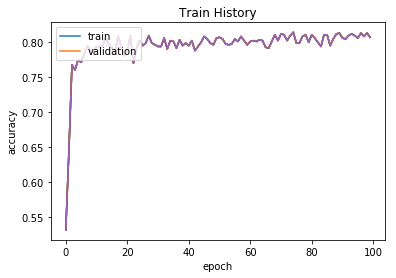

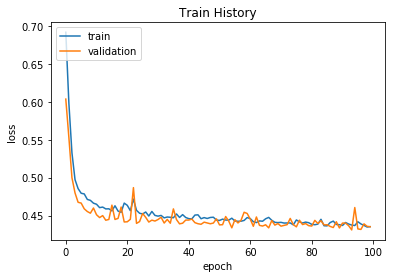

In [23]:
import matplotlib.pyplot as plt
def visu_train_history(train_history, train_metric, validation_metric):
    plt.plot(train_history.history[train_metric])
    plt.plot(train_history.history[validation_metric])
    plt.title('Train History')
    plt.ylabel(train_metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
visu_train_history(train_history, 'accuracy', 'accuracy')
visu_train_history(train_history, 'loss', 'val_loss')

In [24]:
# tensorboard --logdir = C:\code\tensorflow_demo\Keras泰坦尼克号生存预测\logs